<a href="https://colab.research.google.com/github/sohyeon98720/doitDeeplearning/blob/master/doitDeeplearning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 7강 다중분류 : 옷 분류
class MultiClassNetwork():
       
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))   
        return a
    
    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])
        for i in range(epochs):
            loss = 0
            print('.', end='')# 구분에 편리
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1 
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
            
    def training(self, x, y):
        m = len(x)               
        z = self.forpass(x)      
        a = self.softmax(z)      
        err = -(y - a)           
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)  
        return np.argmax(z, axis=1) 
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.softmax(z)    
        a = np.clip(a, 1e-10, 1-1e-10)  
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [5]:
!pip install tensorflow_gpu==2.0.0-rc1

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

     |████████████████████████████████| 380.5MB 37kB/s 
     |████████████████████████████████| 4.3MB 34.5MB/s 
     |████████████████████████████████| 501kB 63.3MB/s 


In [6]:
# 데이터 로드
(x_train_all,y_train_all),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
# 데이터 확인
print(x_train_all.shape,y_train_all.shape)

(60000, 28, 28) (60000,)


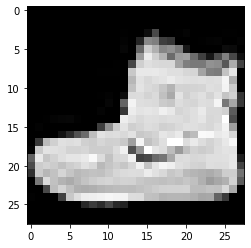

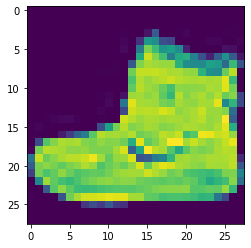

In [8]:
# 데이터 확인 2
plt.imshow(x_train_all[0],cmap='gray')
plt.show()
plt.imshow(x_train_all[0])
plt.show()

In [9]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [0]:
class_names=['티셔츠/윗도리','바지','스워터','드레스','코트',
             '샌들','셔츠','스니커즈','가방','앵클부츠']

In [11]:
# ln[9]를 참조 - y_train_all[9] = 5 -> 5에 해당하는 class_name은 샌들
print(class_names[y_train_all[9]])

샌들


In [12]:
# 데이터 분포 확인
np.unique(y_train_all,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [13]:
# 정수의 빈도수를 세어 반환
# np.unique와 비슷한 용도로 쓸 수 있음
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train_all,y_train_all,stratify=y_train_all,test_size=0.2,random_state=42)

In [0]:
#이미지 정규화(이미지 픽셀범위가 원래 0-255이므로 나눠서 0~1값으로 만듦)
x_train=x_train/255.0
x_val=x_val/255.0

In [16]:
print(x_train.shape)

(48000, 28, 28)


In [0]:
# 차원 변화
x_train=x_train.reshape(48000,-1)

In [18]:
print(x_train.shape)

(48000, 784)


In [0]:
x_val=x_val.reshape(-1,784)

In [20]:
print(x_train.shape,x_val.shape)

(48000, 784) (12000, 784)


In [21]:
# 원 핫 인코딩 설명
tf.keras.utils.to_categorical([0,1,3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [0]:
# 원 핫 인코딩 적용
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)

In [23]:
print(y_train.shape,y_val.shape)
print(y_train_encoded.shape,y_val_encoded.shape)

(48000,) (12000,)
(48000, 10) (12000, 10)


In [24]:
# 원 핫 인코딩이 잘 되었는지 확인
print(class_names[y_train[0]],y_train[0],y_train_encoded[0])

셔츠 6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [25]:
fc=MultiClassNetwork(units=100,batch_size=256)
fc.fit(x_train,y_train_encoded,x_val=x_val,y_val=y_val_encoded,epochs=40)

........................................

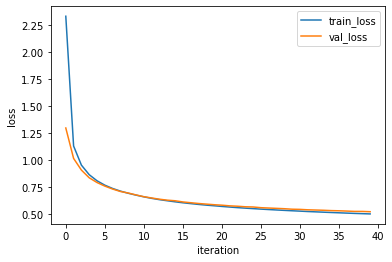

In [26]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [27]:
fc.score(x_val,y_val_encoded)

0.8150833333333334

In [0]:
# keras로 다중 분류 신경망 구현
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model=Sequential()
model.add(Dense(100,activation='sigmoid',input_shape=(784,)))
model.add(Dense(10,activation='softmax'))

In [0]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
history=model.fit(x_train,y_train_encoded,epochs=40,validation_data=(x_val,y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 3s 62us/sample - loss: 1.3725 - acc: 0.6341 - val_loss: 0.9600 - val_acc: 0.7315
Epoch 2/40
48000/48000 [==============================] - 3s 61us/sample - loss: 0.8440 - acc: 0.7398 - val_loss: 0.7520 - val_acc: 0.7569
Epoch 3/40
48000/48000 [==============================] - 3s 63us/sample - loss: 0.7135 - acc: 0.7616 - val_loss: 0.6657 - val_acc: 0.7785
Epoch 4/40
48000/48000 [==============================] - 3s 61us/sample - loss: 0.6486 - acc: 0.7775 - val_loss: 0.6141 - val_acc: 0.7919
Epoch 5/40
48000/48000 [==============================] - 3s 61us/sample - loss: 0.6065 - acc: 0.7918 - val_loss: 0.5777 - val_acc: 0.8013
Epoch 6/40
48000/48000 [==============================] - 3s 63us/sample - loss: 0.5761 - acc: 0.8015 - val_loss: 0.5532 - val_acc: 0.8084
Epoch 7/40
48000/48000 [==============================] - 3s 62us/sample - loss: 0.5528 - acc: 0.8088 - val_loss: 0.

In [32]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


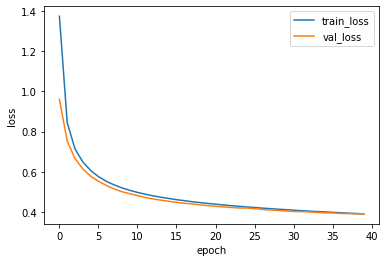

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

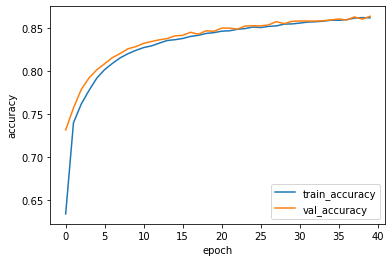

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [37]:
loss,accuracy=model.evaluate(x_val,y_val_encoded,verbose=2)
print(accuracy)
# 성능이 조금 낮은 이유는 이미지 데이터에 맞는 모델이 아니기 때문
# 개선방안 -> CNN(8강)

12000/12000 - 0s - loss: 0.3911 - acc: 0.8634
0.8634167
